# Detailed neuron model (Brette & Gerstner, 2005) + aEIF


In [193]:
import brian2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 7)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

title_fontsize = 36
ax_fontsize = 28
label_fontsize = 20

# 0. aEIF

In [194]:
def V_deriv(V_prev,w_now,input_current,parameters):
    
    V_new = (1/parameters['C_aEIF'])*(potential_to_current(V_prev, parameters) - w_now + input_current)
    return V_new

In [195]:
def potential_to_current(V, parameters):
    return - parameters['g_L_aEIF']*(V - parameters['E_L']) + parameters['g_L_aEIF']*parameters['Delta_T']*np.exp((V - parameters['V_traub'])/parameters['Delta_T'])

In [196]:
def w_deriv(w_prev,V_now,parameters):
    
    w_new = (1/parameters['tau_w'])*(parameters['a']*(V_now - parameters['E_L']) - w_prev)
    return w_new

In [197]:
def update_g(g_prev, g_type, parameters,random_AMPA,random_GABA):
    
    if g_type =='AMPA':
        g_new = parameters['g_AMPA'] + (g_prev - parameters['g_AMPA'])*np.exp(-parameters['dt']/parameters['tau_AMPA']) \
        + parameters['A_AMPA']*random_AMPA
        
    elif g_type == 'GABA':
        g_new = parameters['g_GABA'] + (g_prev - parameters['g_GABA'])*np.exp(-parameters['dt']/parameters['tau_GABA']) \
        + parameters['A_GABA']*random_GABA
    
    else :
        raise ValueError('g_type must be either AMPA or GABA')
    
    return g_new

## 1. Model introduction.

(All of this comes from a chain of references : Brette & Gerstner 2005 --> (Destexhe et al. 1998 + (Destexhe et al. 2001 --> Destexhe and Paré, 1999 = **where all the useful equations are**))


The reference model is a single-compartment, Hodgkin & Huxley type model of a regular spiking pyramidal cell with voltage dependent currents $ I_M $, $ I_{Na} $ and $I_K$, which are respectively :
- a voltage-dependent $Na^{+}$ current ;
- a delayed-rectifier $K^+$ current ;
- a non-inactivating $K^+$ current responsible for spike frequency adaptation. 

$I_{Na}$ and $I_K$ are described by Traub & Miles, 1991, while $I_M$ is described by Destexhe and Paré, 1999.

This model is described by the following equations, taken from Destexhe et al., 2001 : 

\begin{align*}
& C_m\frac{dV}{dt} = -g_L(V-E_L)-I_{Na}-I_K-I_M-\frac{1}{a}I_{syn}  \\
& \\
& I_{Na} = \bar{g}_{Na}m^{3}h(V-E_{Na}) \\
& \\
& I_{K} = \bar{g}_{K}n^{4}(V-E_{K}) \\
& \\
& I_{M} = \bar{g}_{M}p(V-E_{K}) \\
\end{align*}

Where $C_m$ is the membrane capacitance, $g_L$ the leak conductance density, $E_L$ the leak reversal potential, $a$ is the total membrane area.

$m$ is a gating variable representing an activation gate, while $h$, $n$ and $p$ are gating variables representing inactivation gates. Those variables are described by differential equations, which leads to a total set of 5 differential equations to describe the model :

\begin{align*}
& C_m\frac{dV}{dt} = -g_L(V-E_L)-I_{Na}-I_K-I_M-\frac{1}{a}I_{syn}  \\
& \\
& \frac{dm}{dt} = \alpha_m(V)(1-m)-\beta_m(V)m \\
& \\
& \frac{dh}{dt} = \alpha_h(V)(1-h)-\beta_h(V)h \\
& \\
& \frac{dn}{dt} = \alpha_n(V)(1-n)-\beta_n(V)n \\
& \\
& \frac{dp}{dt} = \alpha_p(V)(1-p)-\beta_p(V)p \\
\end{align*}



Where, from Destexhe and Paré 1999 + the actual code from Destexhe 1998: 
\begin{align*}
& \alpha_m = \frac{-0.32(V - V_T - 13)}{exp(-(V-V_T-13)/4)-1} \\
& \\
& \beta_m = \frac{0.28(V-V_T-40)}{exp(-(V-V_T-40)/5)-1}  \\
& \\
& \alpha_h = 0.128exp(-(V-V_T-17)/18) \\
& \\
& \beta_h = \frac{4}{1 + exp(-(V-V_T- 40)/5)} \\
& \\
& \alpha_n = \frac{-0.032(V-V_T-15)}{exp(-(V-V_t-15)/5)-1} \\
& \\
&  \beta_n = 0.5exp(-(V-V_T-10)/40) \\
& \\
& \alpha_p = \frac{0.0001(V + 30)}{1-exp(-(V+30)/9)} \\
& \\
& \beta_p = \frac{-0.0001(V + 30)}{1-exp((V+30)/9)} \\
\end{align*}

Where $V_T = -55 mV$ ($V_{traub}$ in the code of Destexhe 1998)

In [198]:
def alpha(channel, V, V_traub):
    V = V / brian2.mV
    V_traub = V_traub / brian2.mV
    if channel == 'm':
        return (-0.32 * (V - V_traub - 13)) / (np.exp(-(V - V_traub- 13)/4) - 1)
    elif channel == 'h':
        return 0.128 * np.exp(-(V - V_traub - 17)/18)
    elif channel == 'n':
        return (-0.032 * (V - V_traub - 15)) / (np.exp(-(V - V_traub - 15)/5) - 1)
    elif channel == 'p':
        return (0.0001*(V + 30)) / (1 - np.exp(-(V + 30) / 9))

def beta(channel, V, V_traub):
    V = V / brian2.mV
    V_traub = V_traub / brian2.mV
    if channel == 'm':
        return (0.28 * (V - V_traub - 40)) / (np.exp((V - V_traub - 40)/5) - 1)
    elif channel == 'h':
        return 4 / (1 + np.exp(-(V - V_traub - 40)/5)) 
    elif channel == 'n':
        return 0.5 * np.exp(-(V - V_traub - 10)/40)
    elif channel =='p':
        return (-0.0001*(V + 30)) / (1 - np.exp((V + 30) / 9))

Finally, we have :
$$I_{syn} = I_{AMPA} + I_{GABA}$$
_In vivo_-like synaptic activity is modeled by the Ornstein-Uhlenbeck processes describing the two conductances also used for the aEIF model. We have : 

\begin{align*}
& I_{AMPA} = - g_e(t)(V - E_e) \\
&\\
& I_{GABA} = -g_i(t)(V - E_i) \\
\end{align*}
   
   Where $ E_e $ and $ E_i $ are the reversal potentials for the AMPA and GABA currents (respectively). $ g_e(t) $ and  $ g_i(t) $ are respectively the AMPA and GABA conductances and are described by Ornstein-Uhlenbeck processes with respective time constants $ t_e = 2.728 ms $ and $ t_i = 10.49 ms $. 
   
  


As laid out in Destexhe et al., 2001 :
 
\begin{align*}
& \frac{dg_e(t)}{dt} = - \frac{1}{\tau_e}[g_e(t) - g_{e0}] + \sqrt{D_e}\chi_1(t) \\
& \\
&   \frac{dg_i(t)}{dt} = - \frac{1}{\tau_i}[g_i(t) - g_{i0}] + \sqrt{D_i}\chi_2(t) \\
\end{align*}
    
Where $g_{e0} $ and $ g_{i0}$ are average conductances (the mean conductances given in Table 1, simply named $g_e$ and $g_i$ in the Brette & Gerstner), $D_e$ and $D_i$ are noise 'diffusion' coefficients, and $\chi_1(t)$ and $\chi_2(t)$ are Gaussian white noise of zero mean and unit standard deviation.

The update rule for those processes is given by : 

\begin{align*}
& g_e(t+h) = g_{e0} + [g_e(t) - g_{e0}]exp(-\frac{h}{\tau_e}) + A_eN_1(0,1) \\
& \\
&   g_i(t+h) = g_{i0} + [g_i(t) - g_{i0}]exp(-\frac{h}{\tau_i}) + A_iN_2(0,1) \\
\end{align*}
   
$ N_i(0, 1) $ and $ N_2(0, 1) $ are normal random numbers (zero mean, unit SD). $ A_e $ and $A_i$ are amplitude coefficients given by :

\begin{align*}
& A_e = \sqrt{\frac{D_e\tau_e}{2}[1-exp(\frac{-2h}{\tau_e})]} \\
& \\
&   A_i = \sqrt{\frac{D_i\tau_i}{2}[1-exp(\frac{-2h}{\tau_i})]} \\
\end{align*}

Finally, the diffusion coefficients are given by :
$$D = \frac{2\sigma^2}{\tau}$$

In [199]:
def diff_coeff(sigma, tau):
    return (2*sigma**2)/tau

def amp_coeff(diff_coeff, tau, dt):
    return np.sqrt( ((diff_coeff*tau)/2) * (1-np.exp((-2*dt)/tau)))

def updt_g(g_prev, g, tau, dt, amp_coeff, g_type, random_AMPA, random_GABA):
    if g_type =='AMPA':
        g_new = g + (g_prev - g)*np.exp(-dt/tau) + amp_coeff*random_AMPA
        
    elif g_type == 'GABA':
        g_new = g + (g_prev - g)*np.exp(-dt/tau) + amp_coeff*random_GABA
    
    else :
        raise ValueError('g_type must be either AMPA or GABA')
    
    return g_new

## 2. Parameters and model.

Parameters are taken from the available Neuron code from Destexhe 1998 (https://senselab.med.yale.edu/ModelDB/ShowModel?model=3817&file=/cortex/sPY_template#tabs-2)

In [200]:
parameters_aEIF = {}
    
# Physiological parameters
parameters_aEIF.update({ # Conductance
                    'C' : 281 *brian2.pF,
                    'g_L' : 30 * brian2.nS,
                    'g_AMPA': 1/2 * brian2.nS,
                    'g_GABA': 2/3 * brian2.nS,
                    'sigma_AMPA': 1/3 * brian2.nS,
                    'sigma_GABA' : 2/3 * brian2.nS,
                    # Reverse potential
                    'E_L' : - 60 * brian2.mV, #V_reset
                    'E_AMPA' : 0 * brian2.mV, 
                    'E_GABA' : - 75 * brian2.mV,
                    # Spike threshold
                    'V_T' : - 50.4 * brian2.mV,
                    'Delta_T' : 2 * brian2.mV,
                    'V_th' : 20 * brian2.mV,
                    'V_reset' : -70.6 * brian2.mV,
                    # Time constants
                    'tau_w': 144  * brian2.ms,   
                    'tau_AMPA' : 2.728 * brian2.ms,
                    'tau_GABA' : 10.49 * brian2.ms,
                    # Adaptation constants
                    'a': 80  * brian2.nS,    
                    'b': 0.0805  * brian2.nA})
    
# Time
parameters_aEIF.update({'dt': 0.5 * brian2.ms}) 
parameters_aEIF.update({'trial_length': 1 * brian2.second,
                   'start_time': 0 *brian2.second, 
                   'end_time': 1 *brian2.second}) 
    
# Initial Conditions
parameters_aEIF.update({'V_0' : -60 * brian2.mV,
                   'w_0' : 0 * brian2.nA})

# Plotting 
parameters_aEIF.update({'y_min' : -100 * brian2.mV,
                   'y_max' : 0 * brian2.mV})

In [201]:
parameters = {}
    
# Physiological parameters (Destexhe code)
parameters.update({ 
    # Capacitance
    'C' : 1 * (brian2.uF / brian2.cm2),
    # Leak conductance
    'g_L' : 0.1 * (brian2.mS / brian2.cm2),
    'E_L' : -70 * brian2.mV,
    # V-dependent currents
    'g_Na' : 50 * (brian2.mS / brian2.cm2),
    'g_K' : 5 * (brian2.mS / brian2.cm2),
    'g_M' : 0.07 * (brian2.mS / brian2.cm2),
    'E_Na' : 50 * brian2.mV,
    'E_K' : -100 * brian2.mV,
    # Threshold (value from Brette and Gerstner and not Destexhe 98 because otherwise F too high)
    'V_traub' : -50.4 * brian2.mV,
    # Fluctuating conductances
    'g_AMPA': (1/3) * 30 * brian2.nS,
    'g_GABA': (2/3) * 30 * brian2.nS,
    'sigma_AMPA': (1/3) * 30 * brian2.nS,
    'sigma_GABA' : (2/3) * 30 * brian2.nS,
    'tau_AMPA' : 2.728 * brian2.ms,
    'tau_GABA' : 10.49 * brian2.ms,
    'E_AMPA' : 0 * brian2.mV,
    'E_GABA' : -75 * brian2.mV,
    # Area
    'area' : 29000 * brian2.um2
})      

# Complete aEIF
# CANNOT DUPLICATE
parameters.update({'V_0' : -60 * brian2.mV,
                   'w_0' : 0 * brian2.nA,
                    'tau_w': 144  * brian2.ms,   
                    'a': 80  * brian2.nS,    
                    'b': 0.0805  * brian2.nA,
                    'Delta_T' : 2 * brian2.mV})

#MUST DUPLICATE
parameters.update({'C_aEIF' : 281 *brian2.pF,
                    'g_L_aEIF' : 30 * brian2.nS,
                    'V_th' : 20 * brian2.mV,
                    'V_reset' : -70.6 * brian2.mV})

In [202]:
# Conductance regimes

g_paradigms = {
    'LC' : {
        0:[1/3, 2/3, 1/3, 2/3],
        1:[1/3, 2/3, 1/2, 2/3],
        2:[1/2, 1/2, 1/2, 1],
        3:[1/2, 1/2, 2/3, 1],
        4:[1/2, 1/2, 1, 1]
        },
    'MC': {
        0:[1/2, 3/2, 1/2, 2/3],
        1:[2/3, 4/3, 1/3, 1],
        2:[2/3, 4/3, 1/2, 1],
        3:[1/2, 3/2, 1, 1],
        4:[2/3, 4/3, 1, 2]
    },
    'HC': {
        0:[1, 3, 1/2, 1],
        1:[1, 3, 2/3, 4/3],
        2:[1, 3, 1, 1],
        3:[1, 3, 1, 2],
        4:[4/3, 8/3, 2/3, 2]
        }
}


## aEIF model class

In [203]:
class Model(object,):
    def __init__(self, parameters,n_trial=1):
        self.parameters = parameters.copy()       # Model parameters
        
        self.t = self.parameters['t']
        self.dt = self.parameters['dt']
        self.N = int(self.t/self.dt)

    def run(self):
        self.__init__(self.parameters)
       
        # Set up simulation parameters
           # timestep 
        self.num_iterations =  self.N
        num_iterations = self.num_iterations

        # Choose initial values for potential and adaptation variables
        self.V_0 = self.parameters['V_0']
        self.w_0 = self.parameters['w_0']
        
        # Preassign potential and adaptation matrices
        self.V = np.zeros((num_iterations)) * brian2.mV
        self.V[0] = self.V_0
        self.w = np.zeros((num_iterations)) * brian2.nA
        self.w[0] = self.w_0
        
        # Choose stimulus strength
        stim_strength = self.parameters['stim_strength']
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off']
        #stim_strength2 = self.parameters['stim_strength2']
        #self.stim_on2    = self.parameters['stim_on2'] 
        #self.stim_off2   = self.parameters['stim_off2']
        
        # Preassign external inputs
        I_ext      = np.zeros((num_iterations,1)) * brian2.amp
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0] = stim_strength * brian2.cm2
        #I_ext[int(self.stim_on2/self.dt):int(self.stim_off2/self.dt),0] = stim_strength2
    
        # Create matrices in which we can store the currents
        I_AMPA =  np.zeros((num_iterations)) * brian2.pA
        I_GABA =  np.zeros((num_iterations)) * brian2.pA
        
        # Define the total current I
        self.I_total =  np.zeros((num_iterations)) * brian2.pA
        
        # Define noise 
        I_noise = 0 * brian2.pA
        
        # Spike list
        self.spike_list = []
        
        # Compute diffusion coefficients for each conductance
        self.parameters.update({'D_AMPA':(2*self.parameters['sigma_AMPA']**2)/self.parameters['tau_AMPA'],
                                'D_GABA':(2*self.parameters['sigma_GABA']**2)/self.parameters['tau_GABA']})
        
        # Compute amplitude coefficients for each conductance 
        self.parameters.update({'A_AMPA':np.sqrt(((self.parameters['D_AMPA']*self.parameters['tau_AMPA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_AMPA']))),
                                'A_GABA':np.sqrt(((self.parameters['D_GABA']*self.parameters['tau_GABA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_GABA'])))})
        
        # Set the initial conductances : 
        g_AMPA = self.parameters['g_AMPA']
        g_GABA = self.parameters['g_GABA']
        
        for i_t in range(1,num_iterations):
            
            # AMPA
            I_AMPA[i_t-1] = - g_AMPA*(self.V[i_t-1] - self.parameters['E_AMPA'])
            # GABA_A 
            I_GABA[i_t-1] = - g_GABA*(self.V[i_t-1] - self.parameters['E_GABA'])
            # Define total input current 
            self.I_total[i_t-1] = I_AMPA[i_t-1] + I_GABA[i_t-1] + I_ext[i_t-1] + I_noise
            
            # Update the conductances 
            norm_AMPA = parameters['random_vect_AMPA'][i_t]
            norm_GABA = parameters['random_vect_GABA'][i_t]
            g_AMPA = update_g(g_AMPA, 'AMPA', self.parameters,norm_AMPA,norm_GABA)
            g_GABA = update_g(g_GABA, 'GABA', self.parameters,norm_AMPA,norm_GABA)

            # Update the adaptation current
            if self.V[i_t-1] > self.parameters['V_th']:
                self.w[i_t] = self.w[i_t-1] + self.parameters['b']
                self.V[i_t] =  self.parameters['V_reset']
                self.spike_list.append((i_t-1)/self.num_iterations)
            else:
                self.w[i_t] = self.w[i_t-1] + self.dt*w_deriv(self.w[i_t-1],self.V[i_t-1],self.parameters)
                # Update the potential of the two excitatory populations.
                self.V[i_t] = self.V[i_t-1] + self.dt*V_deriv(self.V[i_t-1],self.w[i_t], self.I_total[i_t-1],self.parameters)

    def draw(self,):
        self.__init__(self.parameters)
        
        start_time = 0
        end_time = start_time + self.parameters['t']
        
        fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the potential
        # plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.V[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1)],label = 'V')
        plt.plot(np.arange(start_time,end_time,self.dt),self.V,label = 'V')
        # Plot the adaptation current
        #plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.w[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1)],label = 'w')
        axes = plt.gca()
        #plt.axvspan(self.stim_on,self.stim_off, alpha=0.1,color='g')
        #plt.axvspan(self.stim_on2,self.stim_off2, alpha=0.1,color='r')
        plt.xlabel('time (s)')
        plt.ylabel('Potential (mV)')
        plt.ylim(-0.1, 0)
        #plt.yticks(np.arange((self.parameters['y_min'] / brian2.mV) / 1000, (self.parameters['y_max'] / brian2.mV) / 1000, 0.02), 
        #           np.arange(self.parameters['y_min'] / brian2.mV, self.parameters['y_max'] / brian2.mV, 20))
        #plt.legend()
        plt.show()
        
    def draw_V_I(self,):
        self.__init__(self.parameters)
        I_ext      = np.zeros((self.num_iterations,1)) * brian2.amp
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0] = self.parameters['stim_strength']
        
        fig, axes = plt.subplots(1,2,figsize=(35,8))
        time_abs = np.arange(p_1['start_time'],p_1['end_time'],self.dt)
        axes[0].plot(time_abs,V,lw=2)
        axes[0].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[0].set_ylabel(r"$V$ (V)", fontsize=ax_fontsize)
        axes[0].set_ylim([-0.0060, -0.002])
        #axes[0].legend(fontsize=label_fontsize,loc=(1.04,0))

        axes[1].plot(time_abs,I_ext,lw=2)
        axes[1].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[1].set_ylabel(r"$I$ (nA)", fontsize=ax_fontsize)
        axes[1].set_ylim([-0.1,1])
        #axes[1].legend(fontsize=label_fontsize,loc=(1.04,0))
        plt.show()
          
        
    def extract_V(self,):
        self.__init__(self.parameters)
        return self.V
    
    def extract_spike_list(self,):
        self.__init__(self.parameters)
        return self.spike_list

## Detailed model

In [264]:
class detailedModel():
    
    def __init__(self, parameters):
        self.parameters = parameters.copy()
        
        t = self.parameters['t']
        dt = self.parameters['dt']
        N = int(t/dt)
        
        self.V = self.parameters['V_0']*np.ones(N)
        self.m, self.h, self.n, self.p = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
        self.spike_count = 0
        
    def run(self):
        # Numerical simulation of the Hodgkin-Huxley neuron model
        self.__init__(self.parameters)
        
        # Initialize time params
        t = self.parameters['t']
        dt = self.parameters['dt']
        N = int(t/dt)
        spike_count = 0
        
        # Initialize synaptic conductances
        g_AMPA = self.parameters['g_AMPA']
        g_GABA = self.parameters['g_AMPA']
        
        # Choose stimulus strength
        stim_strength = self.parameters['stim_strength']
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off']
        
        # Preassign external inputs
        global I_ext
        I_ext      = np.zeros(N) * (brian2.uA / brian2.cm2)
        I_ext[int(self.stim_on/dt):int(self.stim_off/dt)] = stim_strength
            
        for i in range(1,N):
            # Update gating variables
            V_traub = self.parameters['V_traub']
            updt_m = alpha('m',self.V[i-1], V_traub)*(1-self.m[i-1])-beta('m',self.V[i-1], V_traub)*self.m[i-1]
            updt_h = alpha('h',self.V[i-1], V_traub)*(1-self.h[i-1])-beta('h',self.V[i-1], V_traub)*self.h[i-1]
            updt_n = alpha('n',self.V[i-1], V_traub)*(1-self.n[i-1])-beta('n',self.V[i-1], V_traub)*self.n[i-1]
            updt_p = alpha('p',self.V[i-1], V_traub)*(1-self.p[i-1])-beta('p',self.V[i-1], V_traub)*self.p[i-1]
            self.m[i] = self.m[i-1] + updt_m*(dt / brian2.ms)
            self.h[i] = self.h[i-1] + updt_h*(dt / brian2.ms)
            self.n[i] = self.n[i-1] + updt_n*(dt / brian2.ms)
            self.p[i] = self.p[i-1] + updt_p*(dt / brian2.ms)
            
   
            # Update voltage dependent currents
            I_leak = self.parameters['g_L'] * (self.parameters['E_L'] - self.V[i-1])
            I_Na = self.parameters['g_Na'] * self.m[i]**3 * self.h[i] * (self.parameters['E_Na'] - self.V[i-1])
            I_K = self.parameters['g_K'] * self.n[i]**4 * (self.parameters['E_K'] - self.V[i-1])
            I_M = self.parameters['g_M'] * self.p[i] * (self.parameters['E_K'] - self.V[i-1])

            # Update synaptic currents 
            I_AMPA = g_AMPA*(self.parameters['E_AMPA'] - self.V[i-1])
            I_GABA = g_GABA*(self.parameters['E_GABA'] - self.V[i-1])
            I_syn = (I_AMPA + I_GABA)

            # Update the conductances 
            norm_AMPA = parameters['random_vect_AMPA'][i]
            norm_GABA = parameters['random_vect_GABA'][i]
            
            diff_coeff_AMPA = diff_coeff(self.parameters['sigma_AMPA'], self.parameters['tau_AMPA'])
            amp_coeff_AMPA = amp_coeff(diff_coeff_AMPA, self.parameters['tau_AMPA'], self.parameters['dt'])
            g_AMPA = updt_g(g_AMPA, self.parameters['g_AMPA'], self.parameters['tau_AMPA'], self.parameters['dt'], amp_coeff_AMPA, 'AMPA', norm_AMPA, norm_GABA)
            
            
            diff_coeff_GABA = diff_coeff(self.parameters['sigma_GABA'], self.parameters['tau_GABA'])
            amp_coeff_GABA = amp_coeff(diff_coeff_GABA, self.parameters['tau_GABA'], self.parameters['dt'])
            g_GABA = updt_g(g_GABA, self.parameters['g_GABA'], self.parameters['tau_GABA'], self.parameters['dt'], amp_coeff_GABA,'GABA', norm_AMPA, norm_GABA)
            
            # Update V
            updt_V = (I_leak + I_Na + I_K + I_M + I_ext[i] + (1 / self.parameters['area']) * I_syn) / self.parameters['C']

            self.V[i] = self.V[i-1] + updt_V*dt
 

            if self.V[i] > 8 * brian2.mV and self.V[i-1] < 8 * brian2.mV:
                self.spike_count += 1

    def draw(self,):
        
        start_time = 0
        end_time = start_time + self.parameters['t']
        
        fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the potential
        plt.plot(np.arange(start_time, end_time,self.parameters['dt']), self.V, label = 'V')
        # Plot the adaptation current
        axes = plt.gca()
        plt.xlabel('time (s)')
        plt.ylabel('Potential (mV)')
        plt.ylim(self.parameters['y_min'], self.parameters['y_max'])
        #plt.yticks(np.arange((self.parameters['y_min'] ) / 1000, (self.parameters['y_max'] ) / 1000, 0.02), 
        #           np.arange(self.parameters['y_min'], self.parameters['y_max'] , 20))
        plt.legend()
        plt.show()
        
    def draw_compare(self,V_aEIF):
        
        start_time = 0
        end_time = start_time + self.parameters['t']
        
        fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the potential
        plt.plot(np.arange(start_time, end_time,p_0['dt']), self.V, '--',label = 'V_detailed', color='b')
        plt.plot(np.arange(start_time, end_time,p_0['dt']), V_aEIF, label = 'V_aEIF', color='b')
        # Plot the adaptation current
        axes = plt.gca()
        plt.xlabel('time (s)')
        plt.ylabel('Potential (mV)')
        plt.ylim(self.parameters['y_min'], self.parameters['y_max'])
        #plt.yticks(np.arange((self.parameters['y_min'] ) / 1000, (self.parameters['y_max'] ) / 1000, 0.02), 
        #           np.arange(self.parameters['y_min'], self.parameters['y_max'] , 20))
        plt.legend()
        plt.show()
        
    def extract_V(self,):
        self.__init__(self.parameters)
        return self.V
    
    def extract_spike_list(self,):
        self.__init__(self.parameters)
        return self.spike_list

## 3. Simulations

In [281]:
# Time
parameters.update({'dt': 0.05 * brian2.ms,
                   't' : 1000 * brian2.ms,})
parameters.update({'N': int(parameters['t']/parameters['dt'])})
    
# Initial Conditions
parameters.update({'V_0' : -60 * brian2.mV})

# Plotting 
parameters.update({'y_min' : -0.1,
                   'y_max' : 0.02})
    
# Ext. current
parameters.update({'stim_strength': 0 * (brian2.uA / brian2.cm2),
            'stim_on': 0* brian2.ms,
            'stim_off': 0 * brian2.ms,
                  })

parameters.update({'random_vect_AMPA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N']),
                   'random_vect_GABA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N'])
                    })

## Fix same parameters for both models

In [282]:
p_0 = parameters.copy()

### Parameter: detailed + Model: detailed

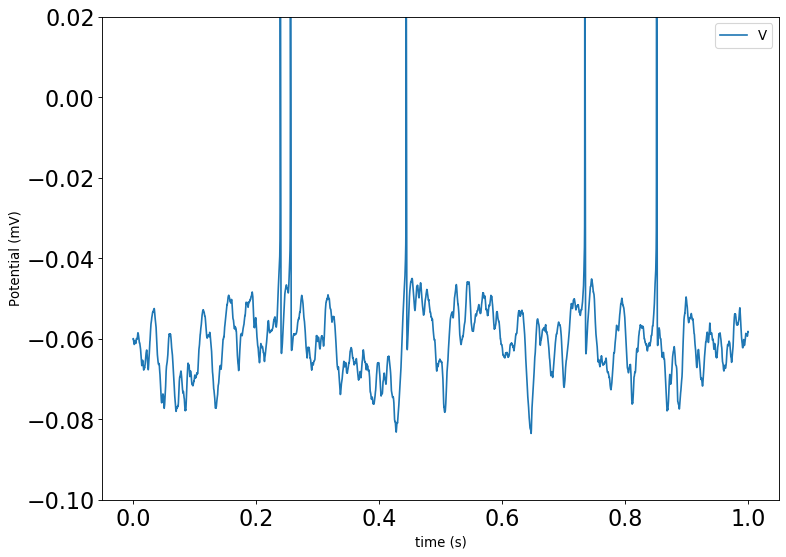

In [283]:

model_0 = detailedModel(p_0)
model_0.run()
fig = model_0.draw()

## Parameter: detailed + Model: aEIF

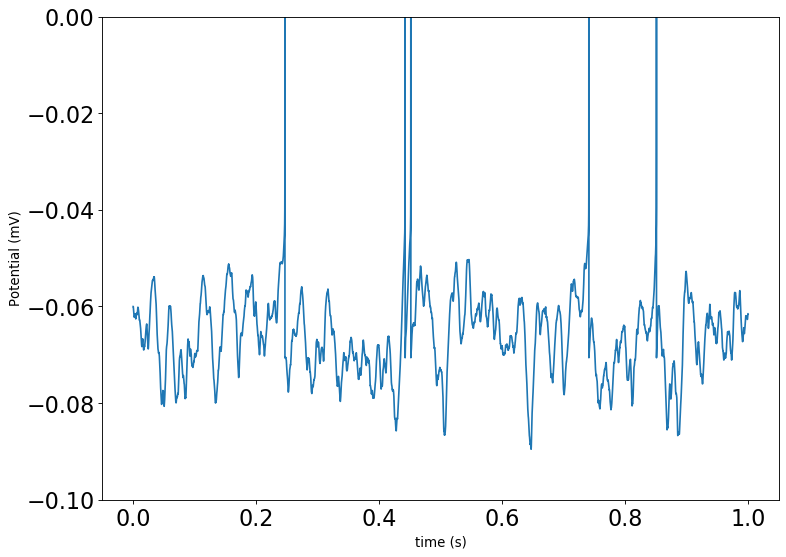

In [284]:
model_1 = Model(p_0)
model_1.run()
fig = model_1.draw()

## Comparison

In [285]:
V_detailed = model_0.extract_V()
V_aEIF = model_1.extract_V()

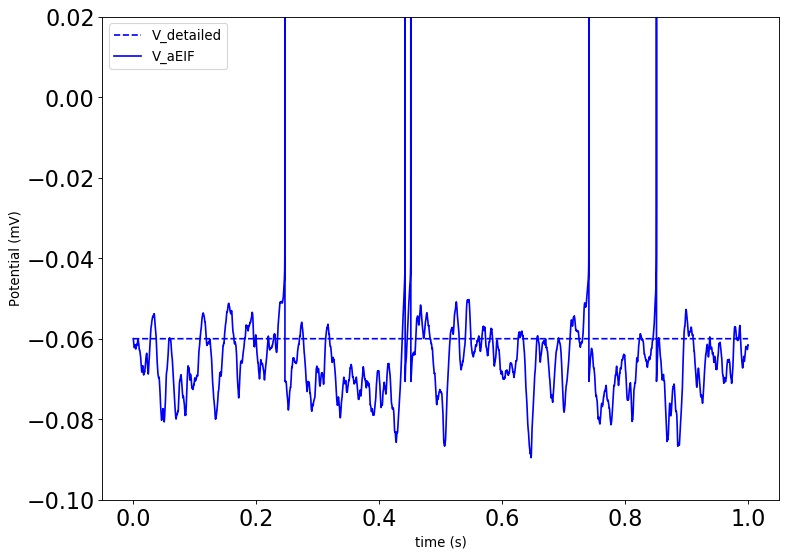

In [286]:
fig_2 = model_0.draw_compare(V_aEIF)

In [287]:
def compare(V_detailed,V_aEIF):
    start_time = 0
    end_time = start_time + p_0['t']
        
    fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 12})
    ax = plt.subplot(1,2,1)
    plt.subplots_adjust(hspace = 1)
    # Plot the potential
    plt.plot(np.arange(start_time, end_time,p_0['dt']), V_detailed, '--',label = 'V_detailed', color='b')
    plt.plot(np.arange(start_time, end_time,p_0['dt']), V_aEIF, label = 'V_aEIF', color='b')
        # Plot the adaptation current
    axes = plt.gca()
    plt.xlabel('time (s)')
    plt.ylabel('Potential (mV)')
    plt.ylim(p_0['y_min'], p_0['y_max'])
        #plt.yticks(np.arange((self.parameters['y_min'] ) / 1000, (self.parameters['y_max'] ) / 1000, 0.02), 
        #           np.arange(self.parameters['y_min'], self.parameters['y_max'] , 20))
    plt.legend()
    plt.show()

In [288]:
V_detailed[2000]

-60. * mvolt

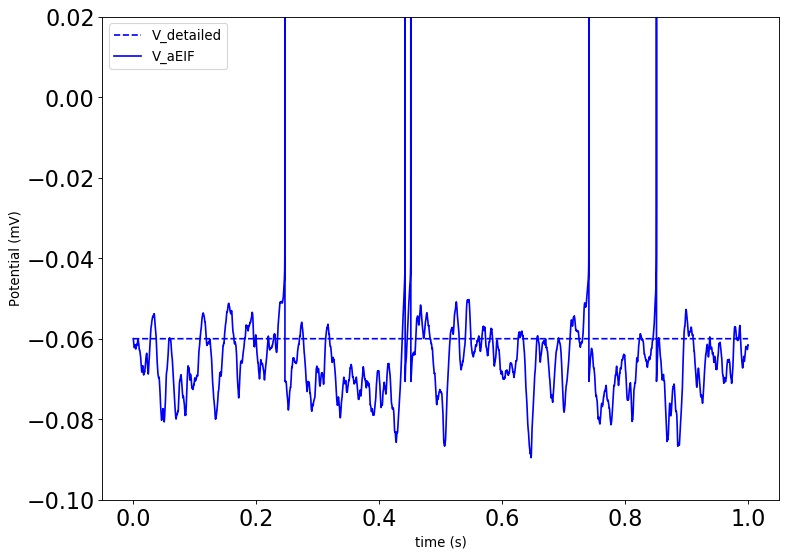

In [289]:
compare(V_detailed,V_aEIF)

## Verification of firing rates

In [ ]:
# Estimation of the firing rate for each conductance injection paradigm

# Time
parameters.update({'dt': 0.05 * brian2.ms,
                   't' : 1000 * brian2.ms}) 
    
# Initial Conditions
parameters.update({'V_0' : -60 * brian2.mV})

# Plotting 
parameters.update({'y_min' : -100 * brian2.mV,
                   'y_max' : 50 * brian2.mV})
    
# Ext. current
parameters.update({'stim_strength': 0 * (brian2.uA / brian2.cm2),
            'stim_on':  250* brian2.ms,
            'stim_off': 500 * brian2.ms,
                  })

# Estimation loop : 
for paradigm in ['LC', 'MC', 'HC']:
    print('{} paradigms :'.format(paradigm))
    for i in range(5):
        conductances = g_paradigms[paradigm][i]
        parameters.update({
            'g_AMPA': conductances[0] * 30 * brian2.nS,
            'g_GABA': conductances[1] * 30 * brian2.nS,
            'sigma_AMPA': conductances[2] * 30 * brian2.nS,
            'sigma_GABA' : conductances[3] * 30 * brian2.nS
        })
        rates = []
        for it in range(10):
            model = detailedModel(parameters)
            model.run()
            rates.append(model.spike_count)
        mean, std = np.mean(rates), np.std(rates)
        print('Paradigm {} : F = ({} +/- {}) Hz'.format(i, mean, std))

LC paradigms :
